In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation

# Generate some random images
'''
input_images, target_masks = simulation.generate_random_data(84, 84, count=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask (Ground-truth)
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])
'''

image_size = 84

'\ninput_images, target_masks = simulation.generate_random_data(84, 84, count=3)\n\nfor x in [input_images, target_masks]:\n    print(x.shape)\n    print(x.min(), x.max())\n\n# Change channel-order and make 3 channels for matplot\ninput_images_rgb = [x.astype(np.uint8) for x in input_images]\n\n# Map each channel (i.e. class) to each color\ntarget_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]\n\n# Left: Input image, Right: Target mask (Ground-truth)\nhelper.plot_side_by_side([input_images_rgb, target_masks_rgb])\n'

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = simulation.generate_random_data(image_size, image_size, count=count)        
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return [image, mask]

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 12

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2000, 'val': 200}

In [4]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

'''
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[3]))
'''

"\n# Get a batch of training data\ninputs, masks = next(iter(dataloaders['train']))\n\nprint(inputs.shape, masks.shape)\nfor x in [inputs.numpy(), masks.numpy()]:\n    print(x.min(), x.max(), x.mean(), x.std())\n\nplt.imshow(reverse_transform(inputs[3]))\n"

In [8]:
from torchsummary import summary
import torch
import torch.nn as nn
import pytorch_unet
from nicer_unet_model import UNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#model = pytorch_unet.UNet(6)
model = UNet(6, depth=3,  merge_mode='concat')
model = model.to(device)

#summary(model, input_shape=(3, 224, 224))

/home/heider/Projects/Github/pytorch-unet/nicer_unet_model.py:208: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
/home/heider/Projects/Github/pytorch-unet/nicer_unet_model.py:209: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


In [9]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6

#model = pytorch_unet.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

finish_model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

cuda
Epoch 0/39
----------
LR 0.0001


/home/heider/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  logging.warning("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.145982, dice: 0.918815, loss: 0.532399
val: bce: 0.018127, dice: 0.701679, loss: 0.359903
saving best model
0m 59s
Epoch 1/39
----------
LR 0.0001
train: bce: 0.017564, dice: 0.501018, loss: 0.259291
val: bce: 0.010466, dice: 0.380594, loss: 0.195530
saving best model
0m 58s
Epoch 2/39
----------
LR 0.0001
train: bce: 0.008639, dice: 0.281141, loss: 0.144890
val: bce: 0.007693, dice: 0.198093, loss: 0.102893
saving best model
0m 59s
Epoch 3/39
----------
LR 0.0001
train: bce: 0.008375, dice: 0.189819, loss: 0.099097
val: bce: 0.007707, dice: 0.171576, loss: 0.089642
saving best model
0m 59s
Epoch 4/39
----------
LR 0.0001
train: bce: 0.007903, dice: 0.168837, loss: 0.088370
val: bce: 0.007000, dice: 0.151746, loss: 0.079373
saving best model
0m 59s
Epoch 5/39
----------
LR 0.0001
train: bce: 0.007238, dice: 0.155231, loss: 0.081235
val: bce: 0.007060, dice: 0.153619, loss: 0.080339
0m 59s
Epoch 6/39
----------
LR 0.0001
train: bce: 0.006780, dice: 0.148081, loss: 0.077431

(3, 6, 84, 84)


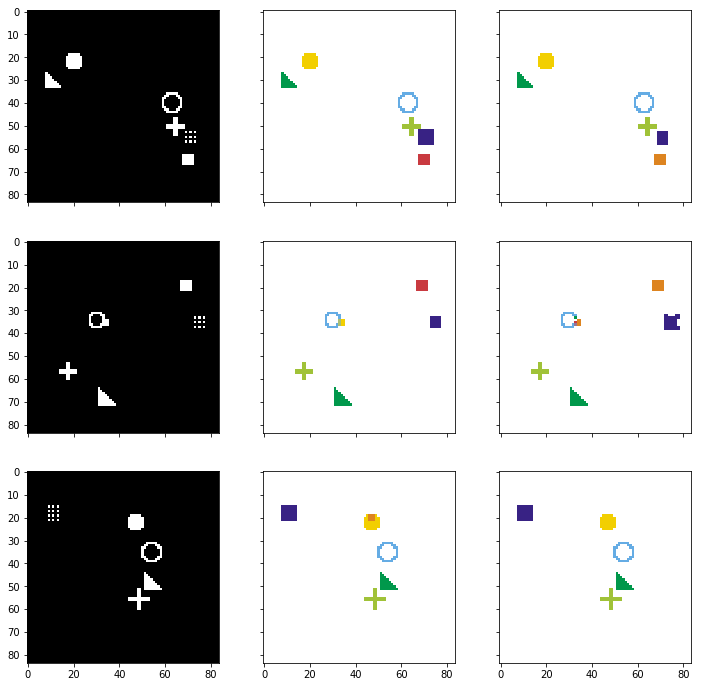

In [11]:
# prediction

import math

finish_model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = finish_model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])